**Коринлов Алексей**


---


**18-АС**


---


**VGG16 and DeepWeeds**


---



В соответствии с csv файлом распределим фотографии по папкам-классам (делал не в colab)

In [ ]:
import shutil
import csv
import pandas as pd

def copy_pictures(file):
    src = "C:\\Users\\Alexey\\Desktop\\Parser\\Parser\\pictures\\" + str(file[0])
    dst = "C:\\Users\\Alexey\\Desktop\\Parser\\Parser\\" + str(file[1]) + "\\" + str(file[0])
    shutil.copyfile(src, dst, follow_symlinks=True)
    print("File " + str(file[0]) + " placed in " + str(file[1]))

def csv_reader():
    df = pd.read_csv('labels.csv', sep=',')
    return df

def df_parser(i,df):
    file = []
    name = df.iloc[i]['Filename']
    label = df.iloc[i]['Label']
    file.append(name)
    file.append(label)
    return file

if __name__ == "__main__":
    df = csv_reader()
    for i in range (0,df.shape[0]):
        file = df_parser(i,df)
        copy_pictures(file)

Установим keras и подключим библиотеки

In [ ]:
!pip install keras-tuner

In [ ]:
import os
import random
import numpy as np
import cv2
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import (Activation, Flatten, MaxPooling2D, BatchNormalization, Conv2D, Dense,
                                            DepthwiseConv2D, Dropout, GlobalAveragePooling2D)
from kerastuner.tuners import Hyperband
import IPython
import tensorflow as tf
from google.colab.patches import cv2_imshow
import keras.regularizers as regularizers
from keras.applications import VGG16
from keras.optimizers import Adam

Зададим глобальные переменные и директории

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ['LAB2_ROOT'] = '/content/drive/My Drive/lab2_dataset'
!mkdir -p "$LAB2_ROOT/images"
OUTPUT_DIRECTORY = "./outputs/"

In [ ]:
img_width = 224
img_height = 224
MAX_EPOCH = 1000
batch_size = 256

In [ ]:
lab2_root = os.getenv('LAB2_ROOT')
image_path = os.path.join(lab2_root, 'images')

train_dir = os.path.join(image_path, 'train')
validation_dir = os.path.join(image_path, 'validation')
test_dir = os.path.join(image_path, 'test')

Добавим генераторы для тренировки, теста, валидации

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)
train_generator.class_indices

Found 12256 images belonging to 9 classes.


{'Chinee apple': 0,
 'Lantana': 1,
 'Negatives': 2,
 'Parkinsonia': 3,
 'Parthenium': 4,
 'Prickly acacia': 5,
 'Rubber vine': 6,
 'Siam weed': 7,
 'Snake weed': 8}

In [ ]:
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 2623 images belonging to 9 classes.


In [ ]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 2630 images belonging to 9 classes.


Выведем по одному изображению для каждого класса

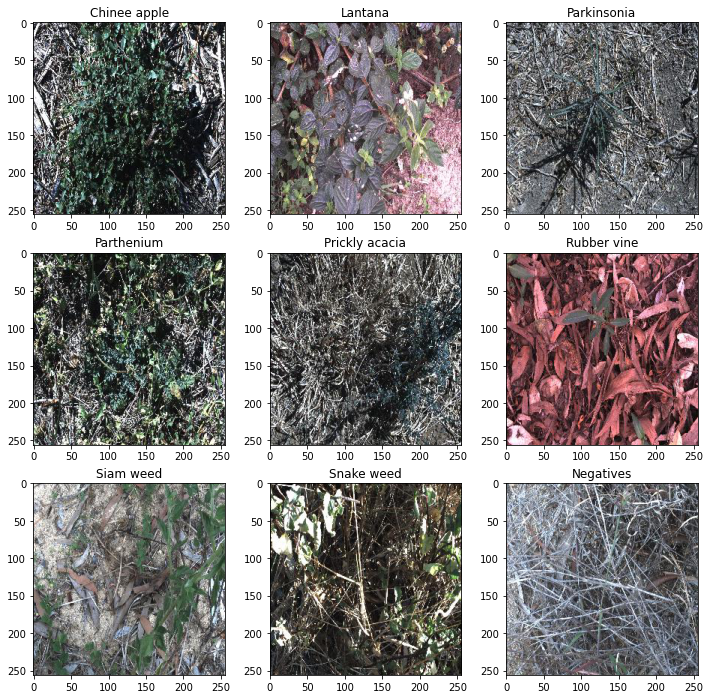

In [ ]:
image_dirs = [
              os.path.join(train_dir, 'Chinee apple'),
              os.path.join(train_dir, 'Lantana'),
              os.path.join(train_dir, 'Parkinsonia'),
              os.path.join(train_dir, 'Parthenium'),
              os.path.join(train_dir, 'Prickly acacia'),
              os.path.join(train_dir, 'Rubber vine'),
              os.path.join(train_dir, 'Siam weed'),
              os.path.join(train_dir, 'Snake weed'),
              os.path.join(train_dir, 'Negatives'),
]

plt.figure(figsize=[12, 12])
for i, path in enumerate([os.path.join(dir, random.choice(os.listdir(dir))) for dir in image_dirs]):
  plt.subplot(3, 3, i+1)
  plt.title(path.split('/')[-2])
  plt.imshow(load_img(path))
plt.show()

За основу модели возьмем предобученную VGG16. Заморозим все обученные слои. Заменим слои вывода.

In [ ]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classifier_activation="softmax",
)
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dense(512, activation='relu', name = 'dense_1')(x)
x = Dense(9, name = 'dense_2')(x)
outputs = Activation(activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

Добавим сохранение лучшей эпохи и защиту от переобучения

In [ ]:
callbacks_list = [
    EarlyStopping(monitor='val_accuracy', mode='max',
                  patience=40, 
                  verbose=0),
    ModelCheckpoint(
    os.path.join(lab2_root, 'best_epoch.h5'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=2)
]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

Обучим нашу модель

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    validation_data = validation_generator,
    validation_steps=validation_generator.n // batch_size,
    epochs= MAX_EPOCH,
    verbose=1,
    callbacks = callbacks_list
    )

Epoch 1/1000
47/47 [==============================] - ETA: 0s - loss: 1.4731 - accuracy: 0.5175
Epoch 00001: val_accuracy improved from 0.52461 to 0.59258, saving model to /content/drive/My Drive/lab2_dataset/best_epoch.h5
47/47 [==============================] - 51s 1s/step - loss: 1.4731 - accuracy: 0.5175 - val_loss: 1.4487 - val_accuracy: 0.5926
Epoch 2/1000
47/47 [==============================] - ETA: 0s - loss: 1.2158 - accuracy: 0.5575
Epoch 00002: val_accuracy did not improve from 0.59258
47/47 [==============================] - 49s 1s/step - loss: 1.2158 - accuracy: 0.5575 - val_loss: 1.3005 - val_accuracy: 0.5477
Epoch 3/1000
47/47 [==============================] - ETA: 0s - loss: 1.1062 - accuracy: 0.5958
Epoch 00003: val_accuracy did not improve from 0.59258
47/47 [==============================] - 49s 1s/step - loss: 1.1062 - accuracy: 0.5958 - val_loss: 1.2778 - val_accuracy: 0.5719
Epoch 4/1000
47/47 [==============================] - ETA: 0s - loss: 1.0381 - accuracy:

Сохраним модель

In [ ]:
model.save('/content/drive/My Drive/lab2_dataset/VGG16_model.h5')

In [ ]:
model.save_weights('/content/drive/My Drive/lab2_dataset/VGG16_model_wieghts.h5')

Нарисуем графики

In [ ]:
def draw_graphics(history):
    history = history.history
    loss = history['loss']
    val_loss = history["val_loss"]
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

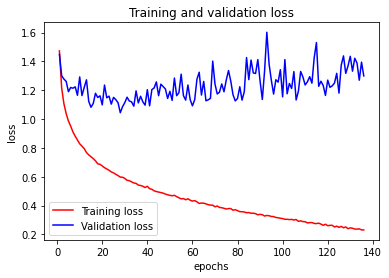

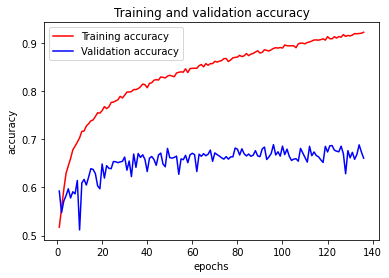

In [ ]:
draw_graphics(history)

Проведем тестирование обученной модели

In [ ]:
def preprocess_image(image):
  return np.expand_dims(img_to_array(image), axis=0) / 255.

In [ ]:
image_paths = [os.path.join(dir, random.choice(os.listdir(dir))) for dir in image_dirs * 1]
classes = ['Chinee apple',
          'Lantana',
          'Negatives',
          'Parkinsonia',
          'Parthenium',
          'Prickly acacia',
          'Rubber vine',
          'Siam weed',
          'Snake weed']

for path in image_paths:
  out = model.predict(preprocess_image(load_img(path)))[0]
  print(dict(zip(classes,[round(x, 4) for x in out])), path.split('/')[-2])

{'Chinee apple': 0.7159, 'Lantana': 0.0005, 'Negatives': 0.1883, 'Parkinsonia': 0.0, 'Parthenium': 0.0, 'Prickly acacia': 0.0, 'Rubber vine': 0.0029, 'Siam weed': 0.0, 'Snake weed': 0.0925} Chinee apple
{'Chinee apple': 0.0, 'Lantana': 0.8403, 'Negatives': 0.0619, 'Parkinsonia': 0.0, 'Parthenium': 0.0, 'Prickly acacia': 0.0, 'Rubber vine': 0.0, 'Siam weed': 0.0977, 'Snake weed': 0.0} Lantana
{'Chinee apple': 0.0003, 'Lantana': 0.0, 'Negatives': 0.0009, 'Parkinsonia': 0.9865, 'Parthenium': 0.0034, 'Prickly acacia': 0.0088, 'Rubber vine': 0.0, 'Siam weed': 0.0, 'Snake weed': 0.0} Parkinsonia
{'Chinee apple': 0.002, 'Lantana': 0.0005, 'Negatives': 0.0208, 'Parkinsonia': 0.0, 'Parthenium': 0.9739, 'Prickly acacia': 0.0002, 'Rubber vine': 0.0, 'Siam weed': 0.0, 'Snake weed': 0.0026} Parthenium
{'Chinee apple': 1e-04, 'Lantana': 0.0, 'Negatives': 0.004, 'Parkinsonia': 0.0, 'Parthenium': 0.0011, 'Prickly acacia': 0.9949, 'Rubber vine': 0.0, 'Siam weed': 0.0, 'Snake weed': 0.0} Prickly acacia


Добавим шумы и протестируем сеть на изображениях с шумом

In [ ]:
S = 1

def get_normal_noise(image):
  noise = np.random.normal(128, 20, (image.shape[0], image.shape[1]))
  return np.dstack((noise, noise, noise)).astype(np.uint8)

def add_normal_noise(image):
  noise = get_normal_noise(image) * S
  noise_image = cv2.add(image.astype(np.float64), noise.astype(np.float64))
  cv2.normalize(noise_image, noise_image, 0, 255, cv2.NORM_MINMAX)
  return noise_image

def get_uniform_noise(image):
  noise = np.random.uniform(0, 255, (image.shape[0], image.shape[1]))
  return np.dstack((noise, noise, noise)).astype(np.uint8)

def add_uniform_noise(image):
  noise = get_uniform_noise(image) * S
  noise_image = cv2.add(image.astype(np.float64), noise.astype(np.float64))
  cv2.normalize(noise_image, noise_image, 0, 255, cv2.NORM_MINMAX)
  return noise_image

test_generator_with_normal_noise = ImageDataGenerator(rescale=1./255, preprocessing_function=add_normal_noise).flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

test_generator_with_uniform_noise = ImageDataGenerator(rescale=1./255, preprocessing_function=add_uniform_noise).flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 2630 images belonging to 9 classes.
Found 2630 images belonging to 9 classes.


Нормальный шум

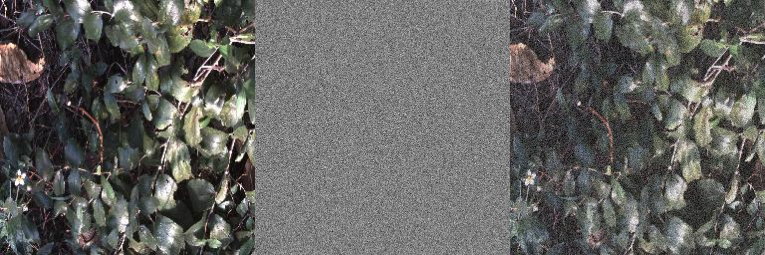

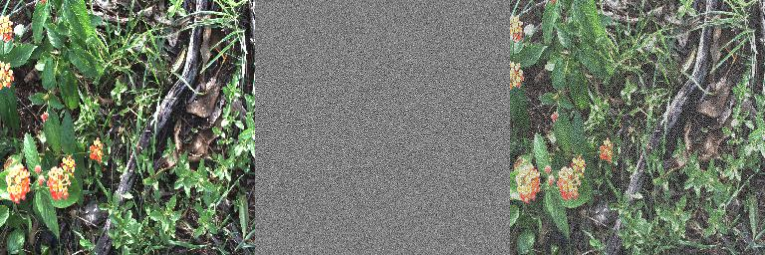

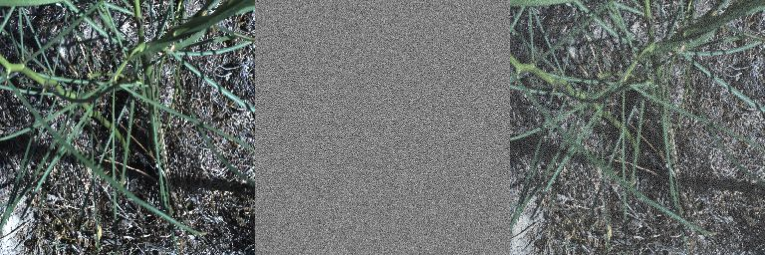

In [ ]:
for i, path in zip(list(range(0, 9, 3)),[os.path.join(dir, random.choice(os.listdir(dir))) for dir in image_dirs]):
  image = cv2.resize(cv2.imread(path), (255, 255))
  cv2_imshow(np.concatenate((image, get_normal_noise(image), add_normal_noise(image)), axis=1))

In [ ]:
loss, accuracy = model.evaluate(test_generator_with_normal_noise)

11/11 [==============================] - 1236s 112s/step - loss: 2.1538 - accuracy: 0.5567


Равномерный шум

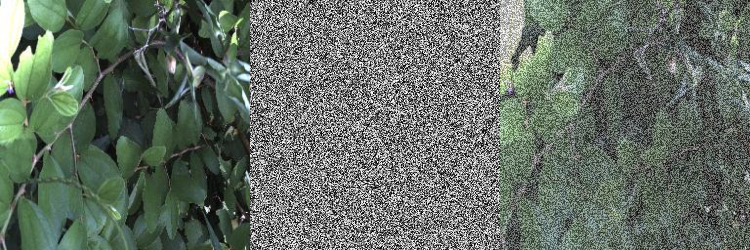

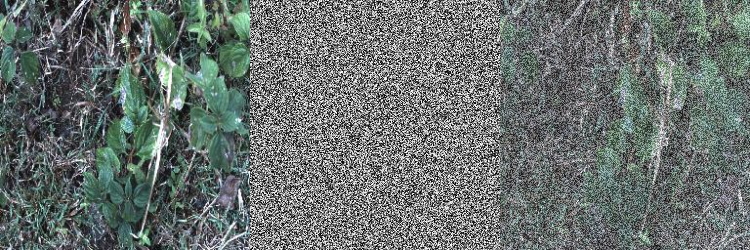

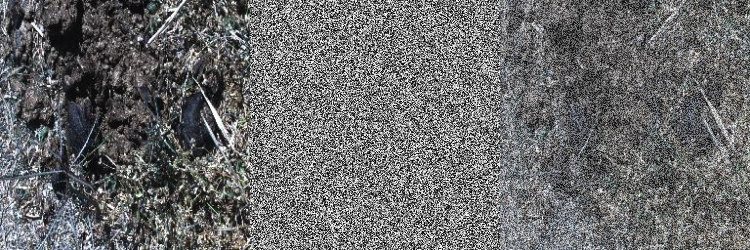

In [ ]:
for i, path in zip(list(range(0, 9, 3)),[os.path.join(dir, random.choice(os.listdir(dir))) for dir in image_dirs]):
  image = cv2.resize(cv2.imread(path), (250, 250))
  cv2_imshow(np.concatenate((image, get_uniform_noise(image), add_uniform_noise(image)), axis=1))

In [ ]:
loss, accuracy = model.evaluate(test_generator_with_uniform_noise)

11/11 [==============================] - 12s 1s/step - loss: 5.2321 - accuracy: 0.5103


Выведем фильтры входного слоя

In [ ]:
 def draw_layer_filters(layer_index):
  filters, biases = model.layers[layer_index].get_weights()
  print(filters.shape)

  filter_list = [filters[:, :, j, i] for i, j in zip(sorted(list(range(filters.shape[-1])) * filters.shape[-2]), list(range(filters.shape[-2])) * filters.shape[-1])]
  rows = filters.shape[-1] if filters.shape[-1] != 1 else 8
  cols = filters.shape[-2] if filters.shape[-1] != 1 else filters.shape[-2] // 8

  plt.figure(figsize=[100, 100])
  for i in range(len(filter_list)):
    plt.subplot(rows, cols, i+1, xticks=([]), yticks=([]))
    plt.imshow(filter_list[i], cmap='gray')
  plt.show()

(3, 3, 3, 64)


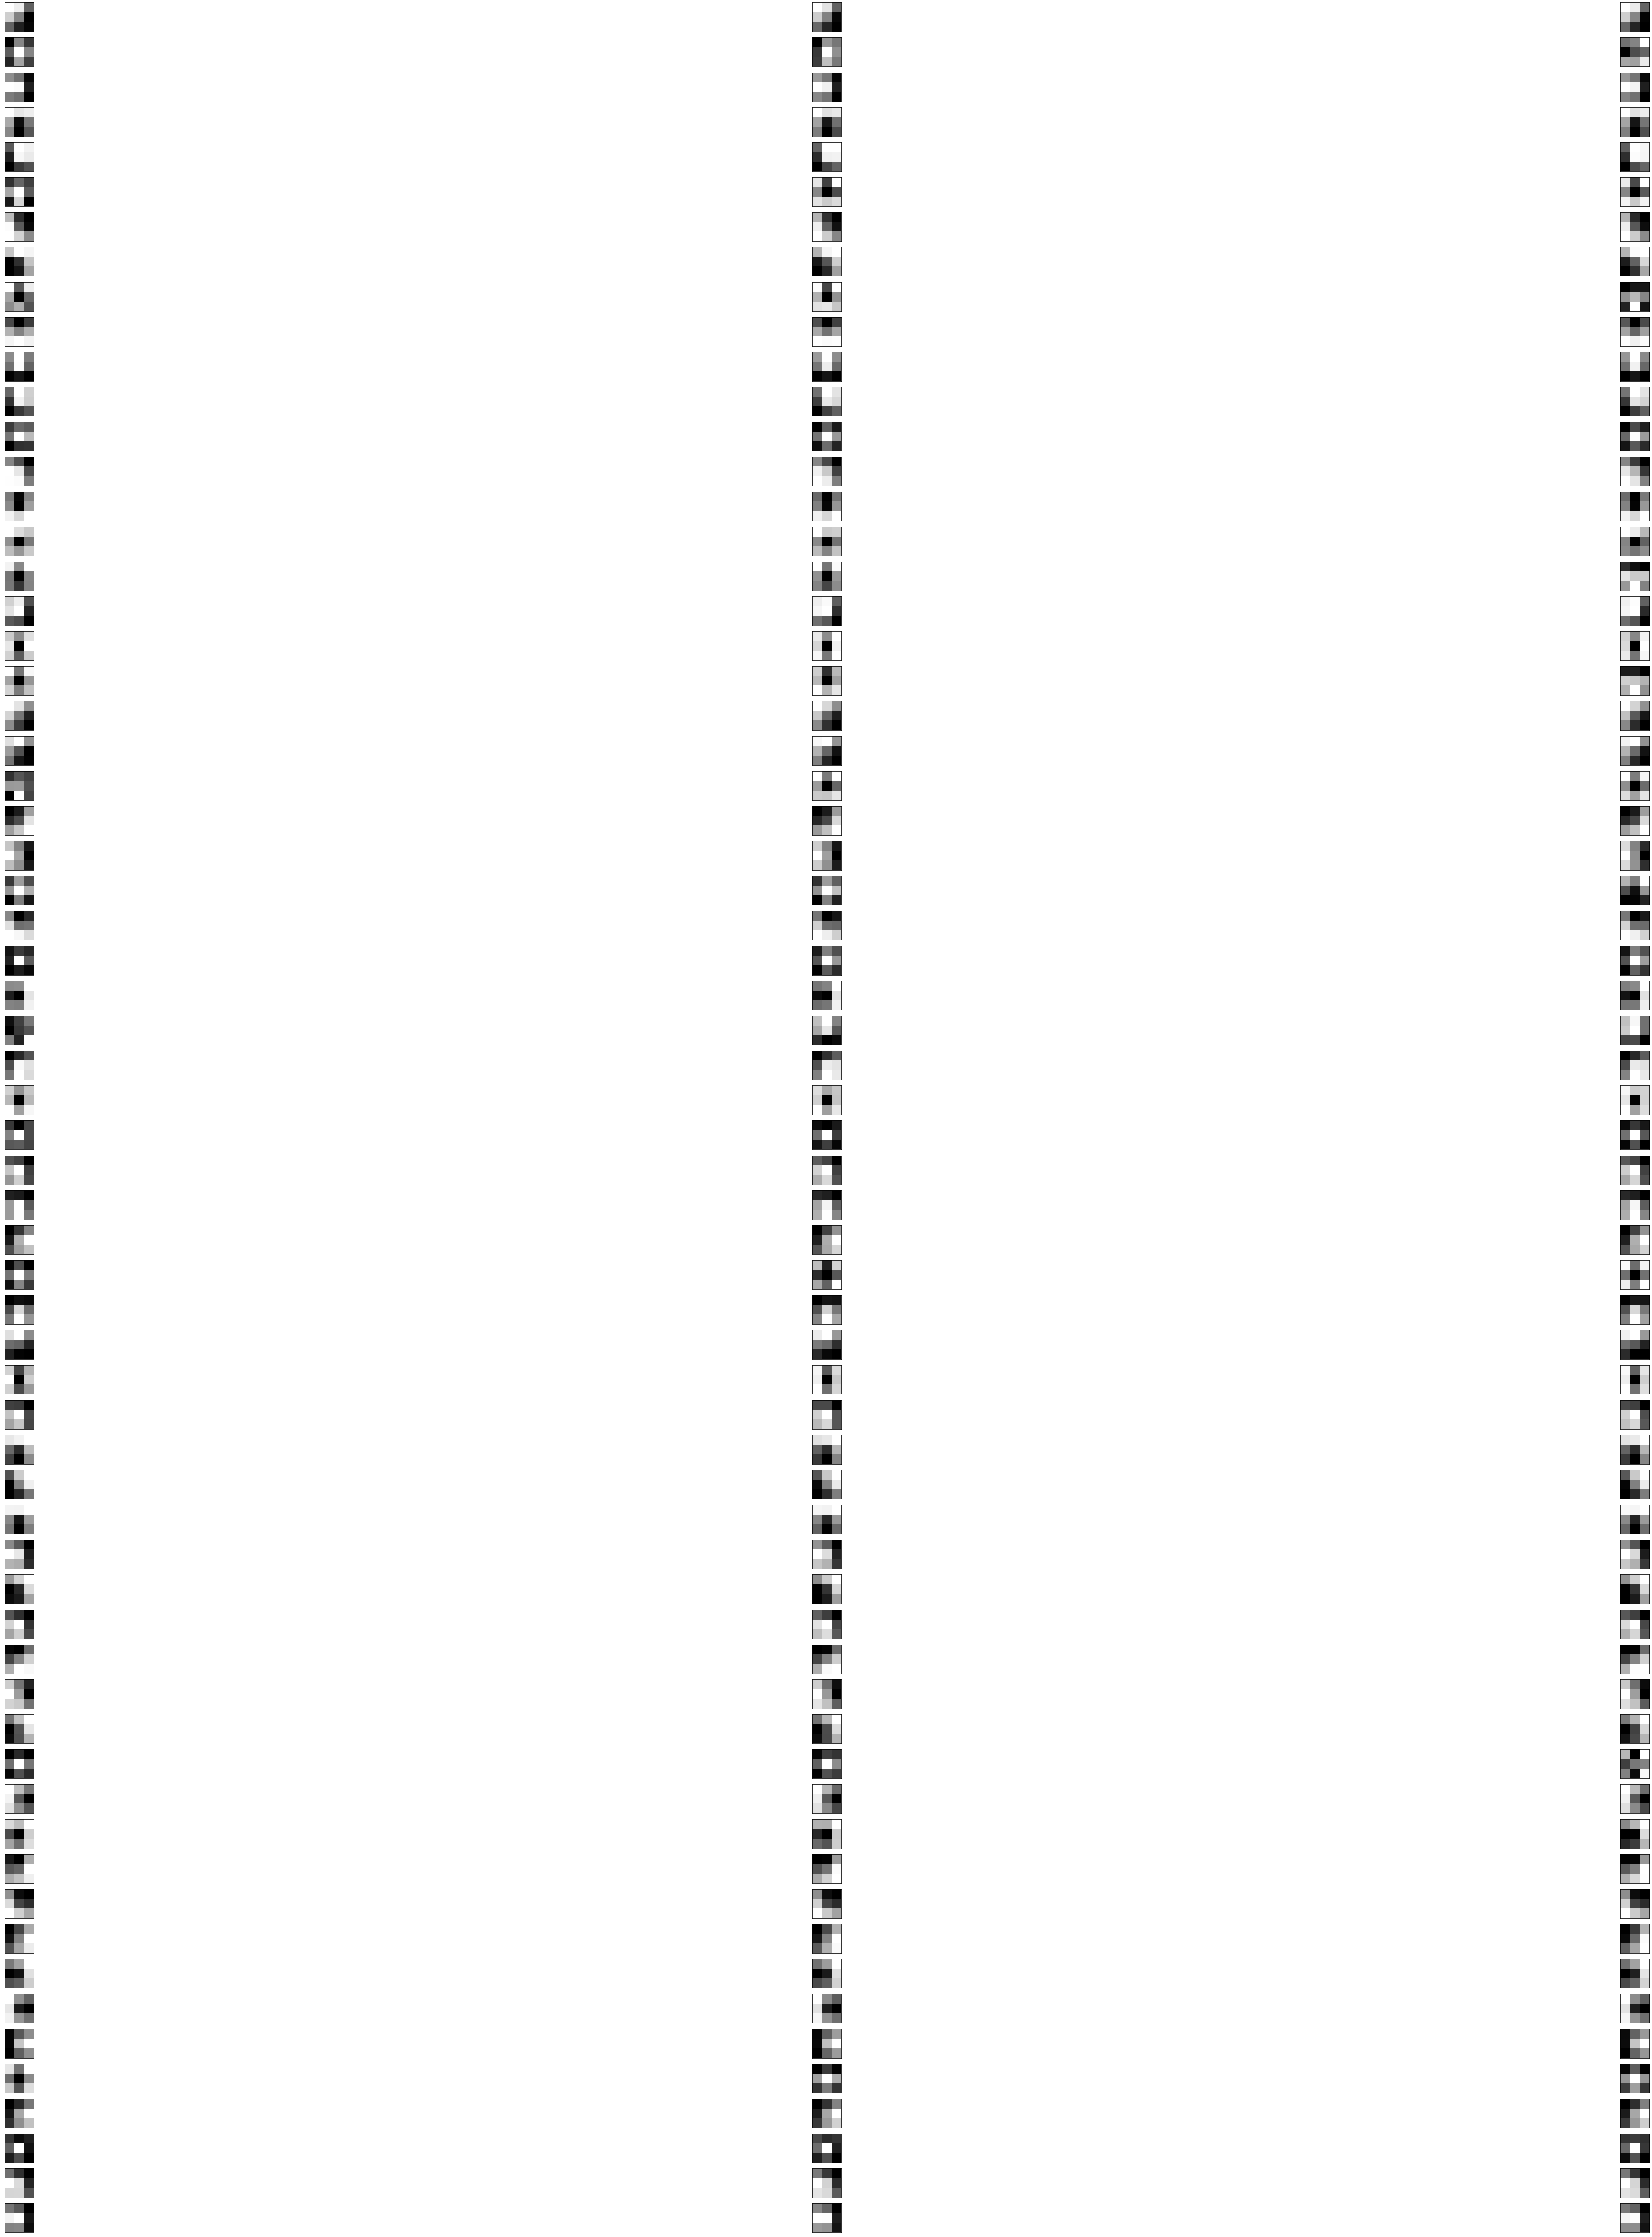

In [ ]:
draw_layer_filters(1)

In [ ]:
def get_feature_maps(original_model, image_tensor, layer_index):
  model = keras.models.Model(inputs=original_model.inputs, outputs=original_model.layers[layer_index].output)
  print(original_model.layers[layer_index].name)
  return model.predict(image_tensor)

In [ ]:
def draw_feature_maps(feature_maps):
  plt.figure(figsize=[64, 64])
  for i, feature_map in enumerate([feature_maps[0, :, :, j] for j in range(3)]):
    plt.subplot(8, 8, i+1, xticks=([]), yticks=([]))
    plt.imshow(feature_map, cmap='gray')
  plt.show()

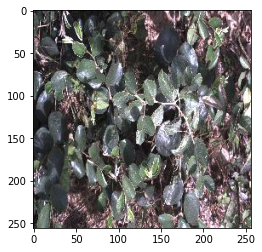

In [ ]:
image_path = '/content/drive/My Drive/lab2_dataset/images/test/Chinee apple/20170811-104056-2.jpg'

image = load_img(image_path)
image_tensor = preprocess_image(image)
plt.imshow(image)

Выведем карты признаков для нескольких слоев

block1_conv1


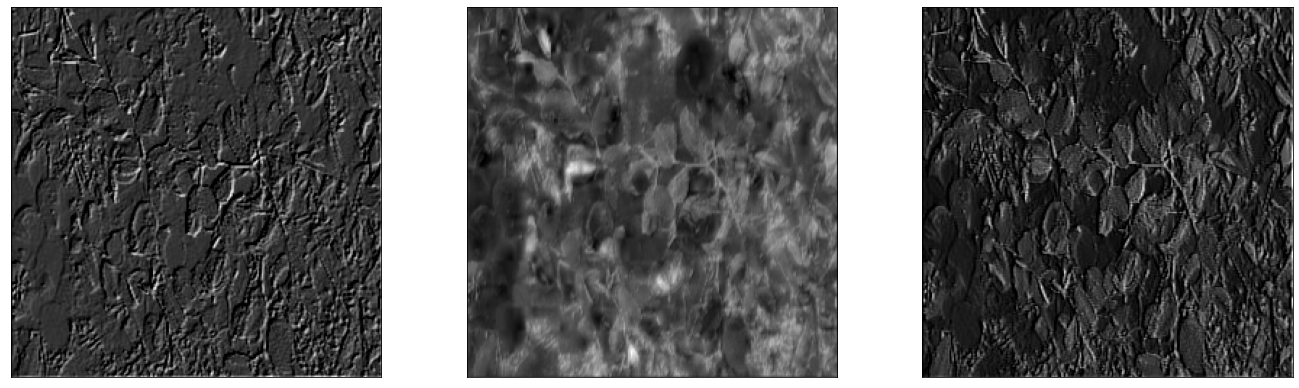

block1_conv2


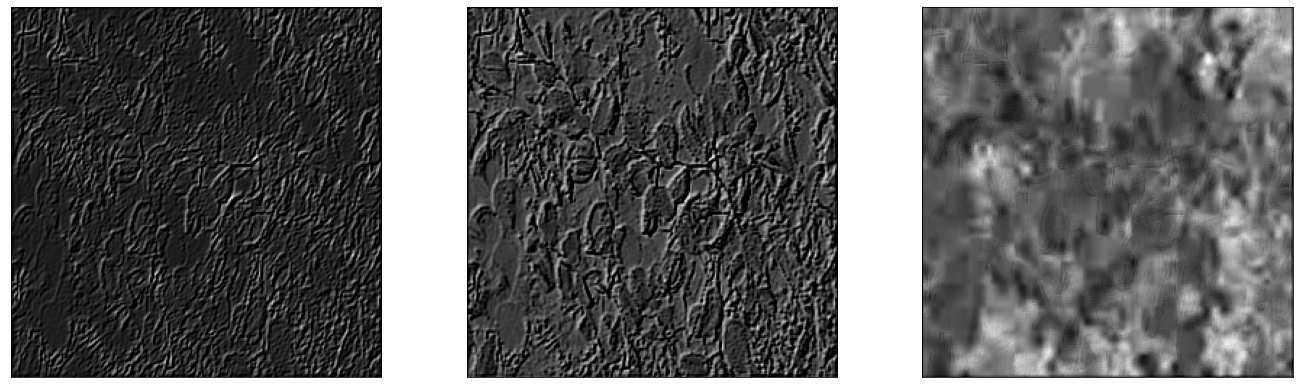

block2_conv1


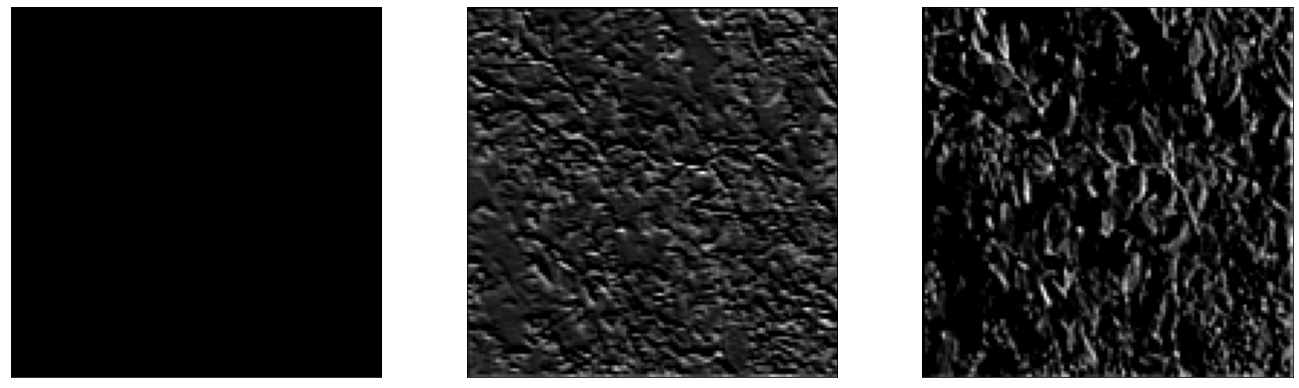

block2_conv2


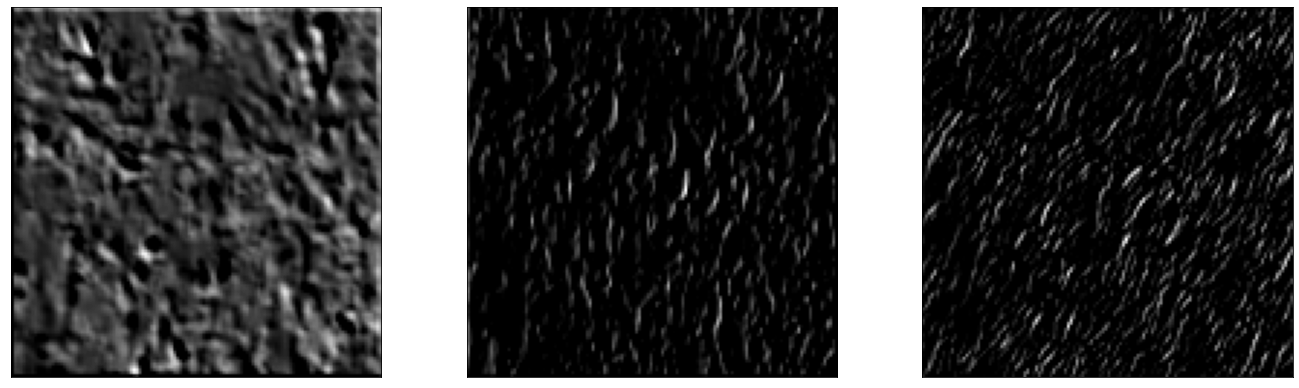

block3_conv1


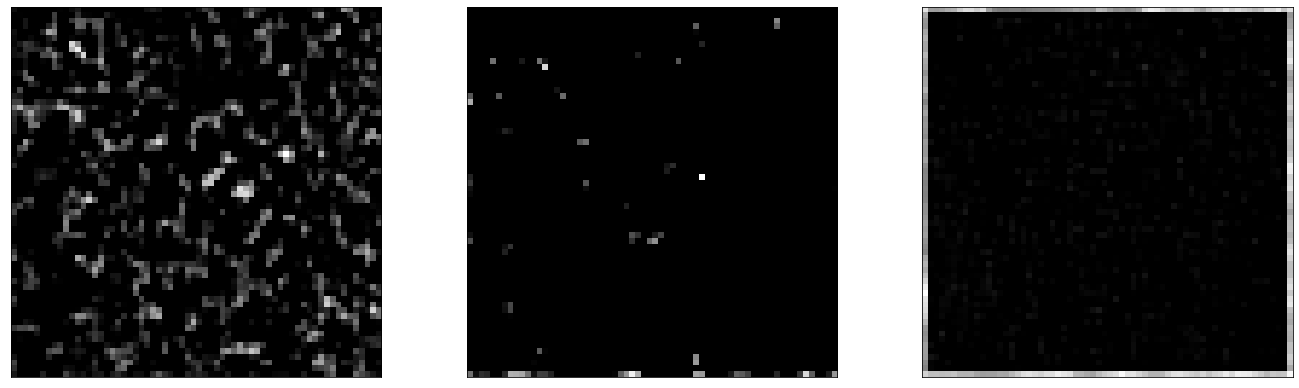

block3_conv2


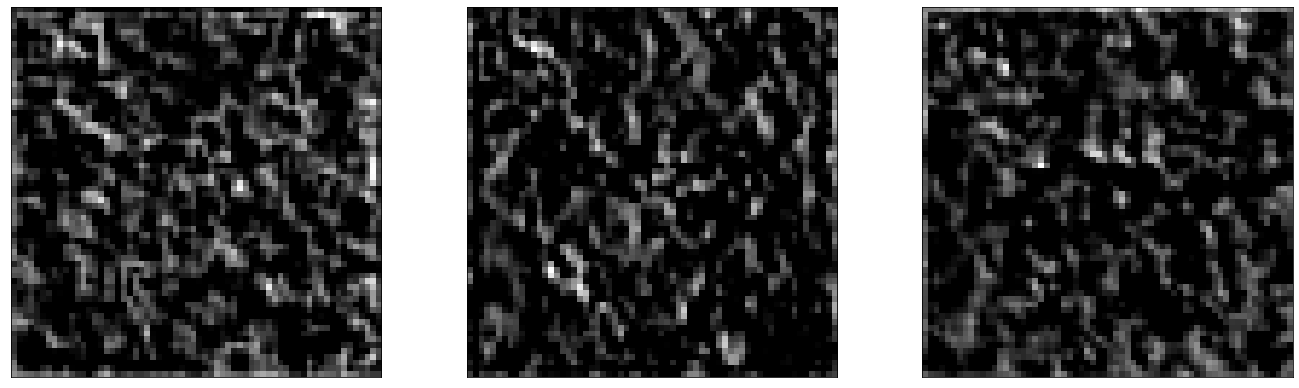

block3_conv3


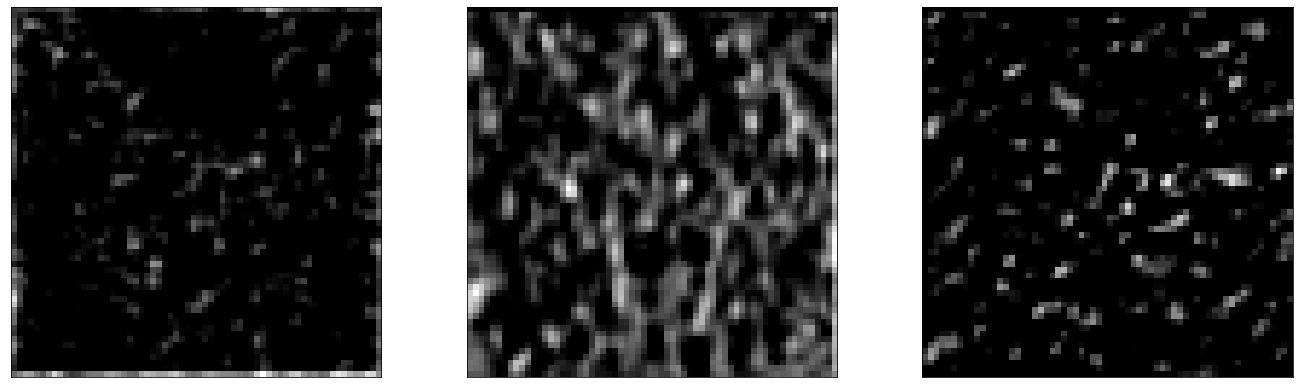

block4_conv1


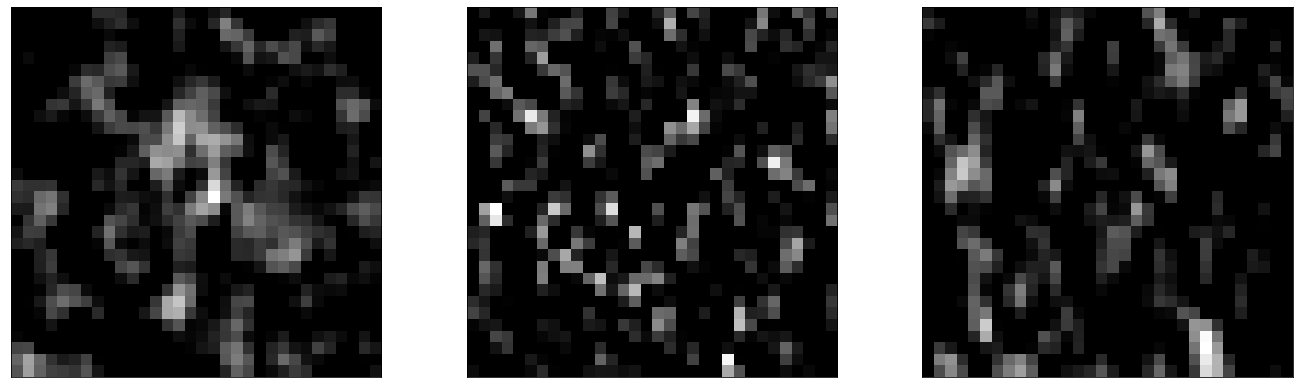

block4_conv2


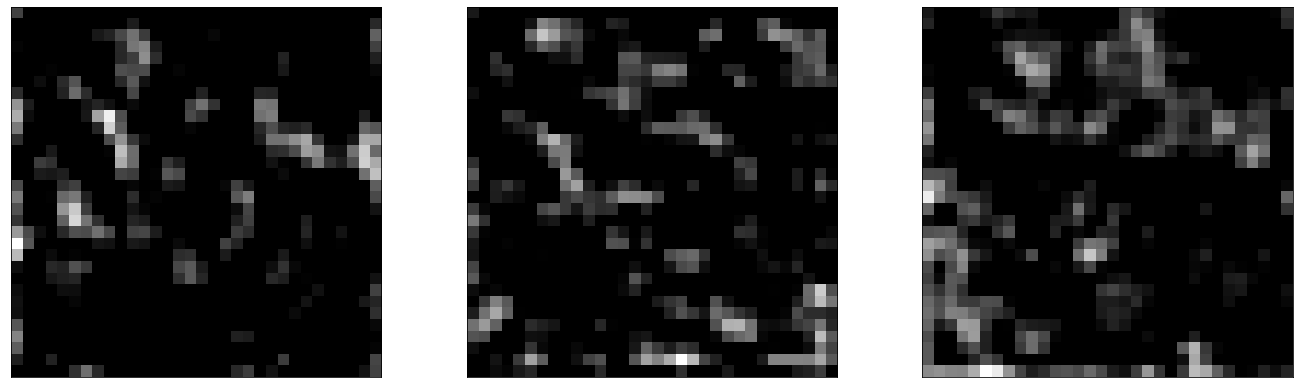

block4_conv3


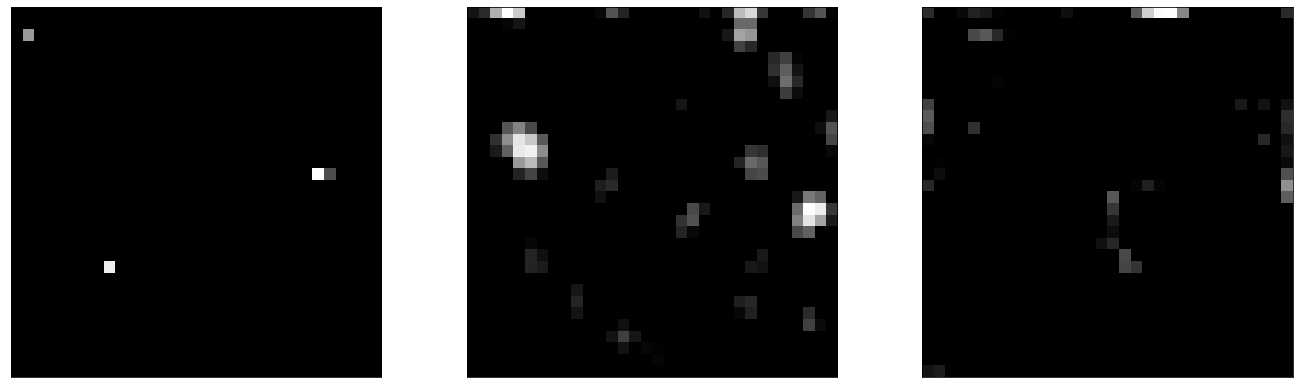

block5_conv1


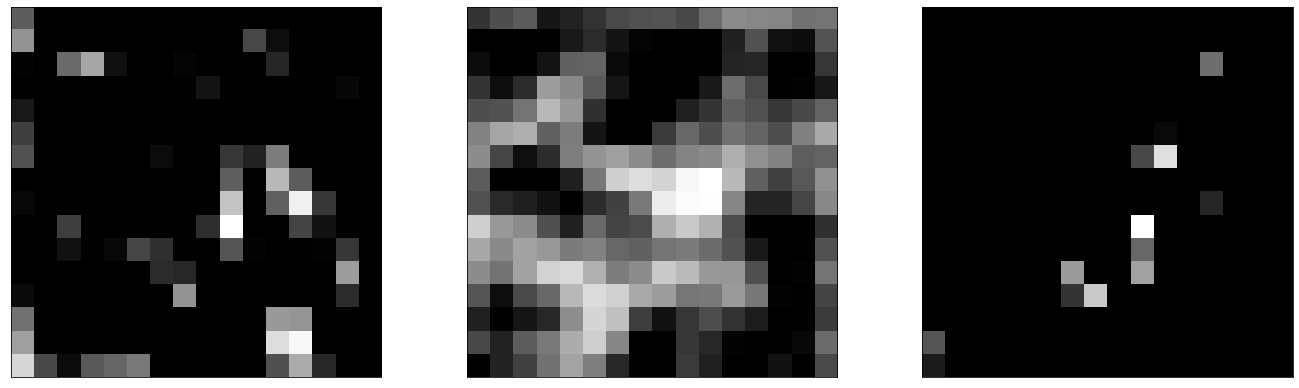

block5_conv2


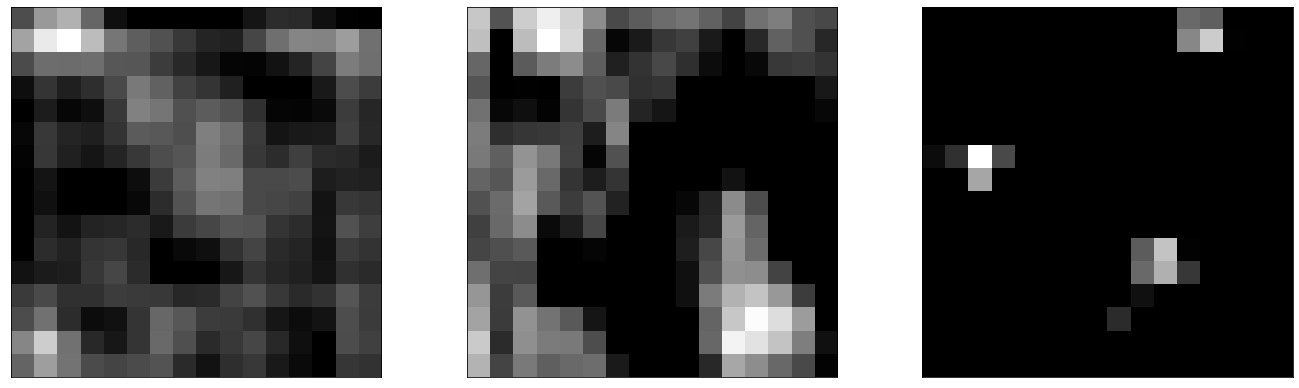

block5_conv3


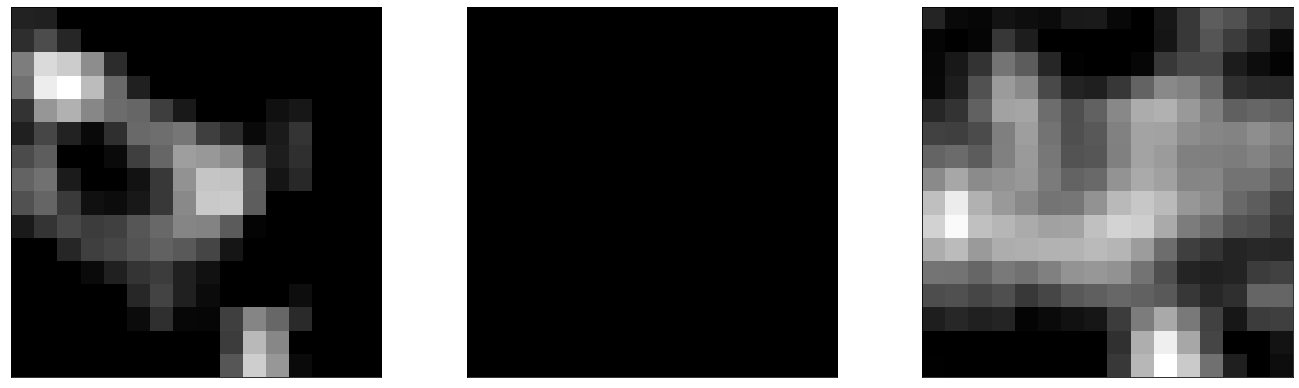

In [ ]:
blocks = []
for i, layer in enumerate(model.layers):
  if 'conv' in layer.name:
      blocks.append(i)
for i in blocks:
  feature_maps = get_feature_maps(model, image_tensor, i)
  draw_feature_maps(feature_maps)